In [1]:
import collections
import os
from os.path import join
import io

import matplotlib.pyplot as plt
import numpy as np
import torch.multiprocessing
import torch.nn as nn
import torch.nn.functional as F
import wget
from PIL import Image
from scipy.optimize import linear_sum_assignment
from torch._six import string_classes
from torch.utils.data._utils.collate import np_str_obj_array_pattern, default_collate_err_msg_format
from torchmetrics import Metric
from torchvision import models
from torchvision import transforms as T
from torch.utils.tensorboard.summary import hparams
import matplotlib as mpl
from PIL import Image

import matplotlib as mpl

import torch.multiprocessing
import torchvision.transforms as T

import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from plotly.subplots import make_subplots

import os   
import cv2
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

colors = ("red", "palegreen", "green", "steelblue", "blue", "yellow", "lightgrey")
class_names = ('Buildings', 'Cultivation', 'Natural green', 'Wetland', 'Water', 'Infrastructure', 'Background')
mapping_class = {
    "Buildings": 1,
    "Cultivation": 2,
    "Natural green": 3,
    "Wetland": 4,
    "Water": 5,
    "Infrastructure": 6,
    "Background": 0,
}

score_attribution = {
    "Buildings" : 0.,
    "Cultivation": 0.3,
    "Natural green": 1.,
    "Wetland": 0.9,
    "Water": 0.9,
    "Infrastructure": 0.,
    "Background": 0.
}
bounds = list(np.arange(len(mapping_class.keys()) + 1) + 1)
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


In [27]:
def plot_imgs_labels(months, imgs, imgs_label, nb_values, scores) :       

    fig2 = px.imshow(np.array(imgs), animation_frame=0, binary_string=True)
    fig3 = px.imshow(np.array(imgs_label), animation_frame=0, binary_string=True)
    
    # Scores 
    scatters = [
        go.Scatter(
            x=list(range(len(months[:i+1]))), 
            y=scores[:i+1], 
            mode="lines+markers+text",  
            marker_color="black",  
            text = [f"{score:.4f}" for score in scores[:i+1]], 
            textposition="top center"
        ) for i in range(len(scores))
    ]
    # scatters = [go.Scatter(y=scores[:i], mode="lines+markers+text", marker_color="black", text = scores[:i], textposition="top center") for i in range(len(scores))]


    # Scores 
    fig = make_subplots(
        rows=1, cols=4,
        specs=[[{"type": "image"},{"type": "image"}, {"type": "pie"}, {"type": "scatter"}]],
        subplot_titles=("Localisation visualization", "Labeled visualisation", "Segments repartition", "Biodiversity scores")
    )

    fig.add_trace(fig2["frames"][0]["data"][0], row=1, col=1)
    fig.add_trace(fig3["frames"][0]["data"][0], row=1, col=2)

    fig.add_trace(go.Pie(labels = class_names,
                values = [nb_values[0][key] for key in mapping_class.keys()],
                marker_colors = colors, 
                name="Segment repartition",
                textposition='inside',
                texttemplate = "%{percent:.0%}",
                textfont_size=14
                ),
                row=1, col=3)


    fig.add_trace(scatters[0], row=1, col=4)
    fig.update_traces(selector=dict(type='scatter'))

    number_frames = len(imgs)
    frames = [dict(
                name = k,
                data = [ fig2["frames"][k]["data"][0],
                        fig3["frames"][k]["data"][0],
                        go.Pie(labels = class_names,
                                values = [nb_values[k][key] for key in mapping_class.keys()],
                                marker_colors = colors, 
                                name="Segment repartition",
                                textposition='inside',
                                texttemplate = "%{percent:.0%}",
                                textfont_size=14
                                ),
                        scatters[k]
                        ],
                traces=[0, 1, 2, 3] # the elements of the list [0,1,2] give info on the traces in fig.data
                                        # that are updated by the above three go.Scatter instances
                ) for k in range(number_frames)]

    updatemenus = [dict(type='buttons',
                        buttons=[dict(label='Play',
                                    method='animate',
                                    args=[[f'{k}' for k in range(number_frames)], 
                                            dict(frame=dict(duration=500, redraw=False), 
                                                transition=dict(duration=0),
                                                easing='linear',
                                                fromcurrent=True,
                                                mode='immediate'
                                                                    )])],
                        direction= 'left', 
                        pad=dict(r= 10, t=85), 
                        showactive =True, x= 0.1, y= 0.13, xanchor= 'right', yanchor= 'top')
                ]

    sliders = [{'yanchor': 'top',
                'xanchor': 'left', 
                'currentvalue': {'font': {'size': 16}, 'prefix': 'Frame: ', 'visible': False, 'xanchor': 'right'},
                'transition': {'duration': 500.0, 'easing': 'linear'},
                'pad': {'b': 10, 't': 50}, 
                'len': 0.9, 'x': 0.1, 'y': 0, 
                'steps': [{'args': [[k], {'frame': {'duration': 500.0, 'easing': 'linear', 'redraw': False},
                                        'transition': {'duration': 0, 'easing': 'linear'}}], 
                        'label': months[k], 'method': 'animate'} for k in range(number_frames)       
                        ]}]


    fig.update(frames=frames)

    for i,fr in enumerate(fig["frames"]):
        fr.update(
            layout={
                "xaxis": {
                            "range": [0,imgs[0].shape[1]+i/100000]
                        },
                "yaxis": {
                            "range": [imgs[0].shape[0]+i/100000,0]
                        },
            })
        
        fr.update(layout_title_text= months[i])


    fig.update(layout_title_text= months[0])
    fig.update(
            layout={
                "xaxis": {
                            "range": [0,imgs[0].shape[1]+i/100000],
                            'showgrid': False, # thin lines in the background
                            'zeroline': False, # thick line at x=0
                            'visible': False,  # numbers below
                        },

                "yaxis": {
                            "range": [imgs[0].shape[0]+i/100000,0],
                            'showgrid': False, # thin lines in the background
                            'zeroline': False, # thick line at y=0
                            'visible': False,},
                            
                "xaxis2": {
                            "range": [0,imgs[0].shape[1]+i/100000],
                            'showgrid': False, # thin lines in the background
                            'zeroline': False, # thick line at x=0
                            'visible': False,  # numbers below
                        },

                "yaxis2": {
                            "range": [imgs[0].shape[0]+i/100000,0],
                            'showgrid': False, # thin lines in the background
                            'zeroline': False, # thick line at y=0
                            'visible': False,},
                            
                
                "xaxis3": {
                            "tickmode": "array",
                            "ticktext": months,
                            "tickvals": months,
                            "range": [0,len(months)],
                    'autorange': False,
#                             'showgrid': False, # thin lines in the background
#                             'zeroline': False, # thick line at y=0
#                             'visible': True,
                },
                "yaxis3": {
                            "range": [min(scores) * 0.9,max(scores) * 1.1],
                            'autorange': False,
                            'showgrid': False, # thin lines in the background
                            'zeroline': False, # thick line at y=0
                            'visible': True # thin lines in the background
                         }   
            }
            )


    fig.update_layout(updatemenus=updatemenus,
                    sliders=sliders,
                    legend=dict(
                        yanchor= 'top',
                        xanchor= 'left', 
                        orientation="h")
    )



    fig.update_layout(margin=dict(b=0, r=0))
    return fig


In [28]:
months = ["2022", "2023", "2024", "2025"]
imgs = [cv2.imread("output/label.png"), cv2.imread("output/img.png"),cv2.imread("output/img.png"), cv2.imread("output/label.png")]
imgs_label = [cv2.imread("output/img.png"), cv2.imread("output/label.png"),cv2.imread("output/img.png"), cv2.imread("output/label.png")]
nb_values = [{
    "Buildings": 10,
    "Cultivation": 20,
    "Natural green": 30,
    "Wetland": 40,
    "Water": 5,
    "Infrastructure": 6,
    "Background": 0,
}
,{
    "Buildings": 10,
    "Cultivation": 20,
    "Natural green": 3,
    "Wetland": 4,
    "Water": 5,
    "Infrastructure": 6,
    "Background": 0,
},{
    "Buildings": 10,
    "Cultivation": 20,
    "Natural green": 3,
    "Wetland": 4,
    "Water": 5,
    "Infrastructure": 6,
    "Background": 0,
},{
    "Buildings": 10,
    "Cultivation": 20,
    "Natural green": 3,
    "Wetland": 4,
    "Water": 5,
    "Infrastructure": 6,
    "Background": 0,
}
]
scores = [0.89, 0.8, 0.7, 0.4]


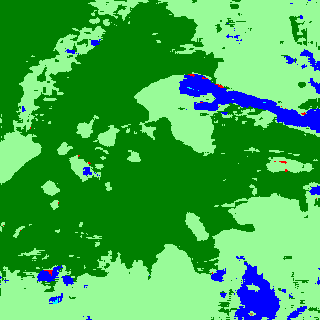
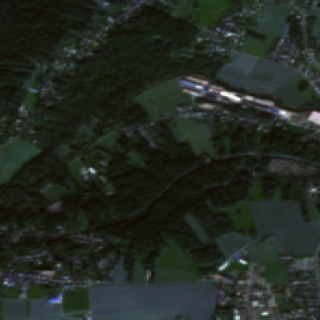
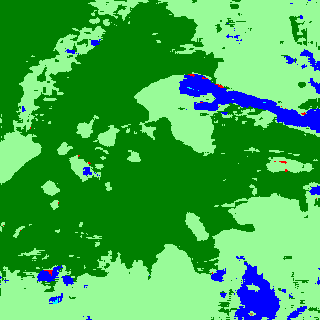
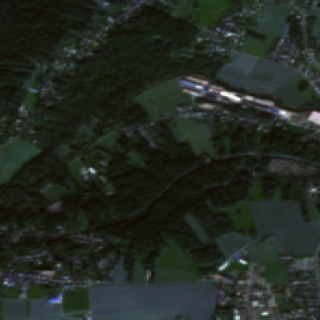
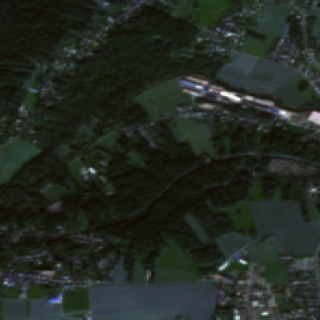
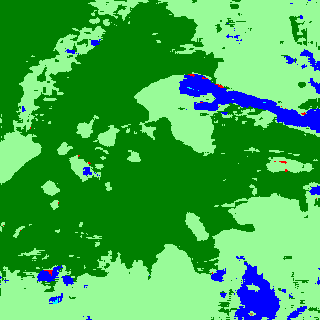
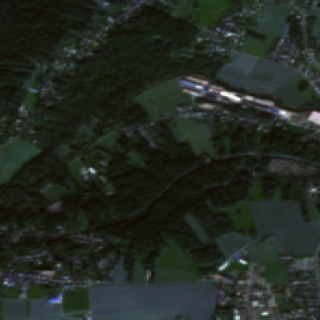
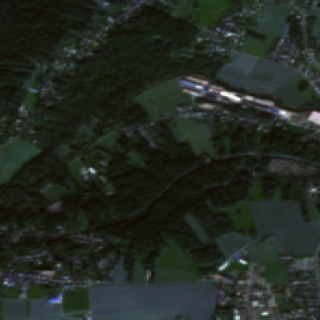
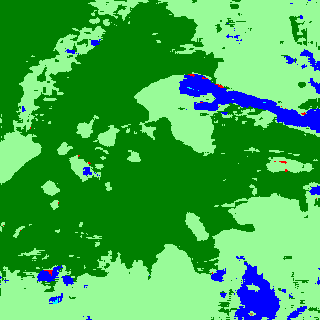
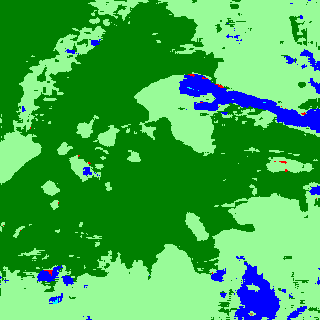

In [29]:
plot_imgs_labels(months, imgs, imgs_label, nb_values, scores)

In [34]:
list(range(4))

[0, 1, 2, 3]